In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import pandas as pd

from torch import nn

from fastai import *
from fastai.vision import *

In [3]:
np.random.seed(42)
path = Path('../data/imgs')

In [4]:
imgs_df = pd.read_csv('../data/driver_imgs_list.csv')
valid_subjects = imgs_df.subject.sort_values().unique()[-6:]
imgs_df['is_valid'] = imgs_df['subject'].isin(valid_subjects)
imgs_df['img_path'] = imgs_df.classname + '/' + imgs_df.img
valid_names = imgs_df[imgs_df['subject'].isin(valid_subjects)].img
valid_names = valid_names.to_list()

data = (ImageList.from_df(df=imgs_df, path='../data/imgs/train/', cols='img_path')
        .split_by_valid_func(lambda o: os.path.basename(o) in valid_names)
        .label_from_df(1)
        .transform(tfms=get_transforms(do_flip=False), size=224)
        .add_test_folder('../test')
        .databunch(bs=64))

In [7]:
learn = cnn_learner(data, 
                    models.densenet201, 
                    loss_func=nn.CrossEntropyLoss(), 
                    metrics=[accuracy, FBeta(average='macro')])

In [8]:
learn.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.264779,1.793431,0.549935,0.545963,03:03
1,0.085068,1.514323,0.640551,0.639209,02:49
2,0.039071,1.612636,0.641842,0.644448,02:49


In [9]:
learn.save('densenet201-stage-1')

In [10]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


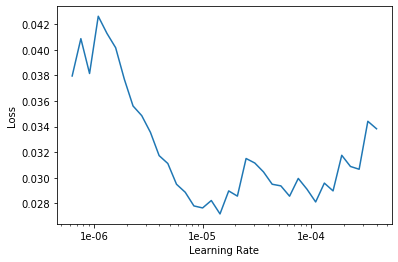

In [12]:
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(3, max_lr=slice(3e-6, 7e-4))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.043608,1.152059,0.733965,0.734800,03:20
1,0.020153,1.155056,0.719759,0.725010,03:21
2,0.009095,1.221394,0.719113,0.724380,03:21


In [14]:
learn.save('densenet201-stage-2')

In [20]:
learn.fit_one_cycle(3, max_lr=slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.007839,1.183044,0.722342,0.728477,03:21
1,0.004981,1.260204,0.707060,0.712626,03:21
2,0.005022,1.212668,0.714593,0.720096,03:21


In [21]:
learn.fit_one_cycle(3, max_lr=slice(1e-7, 5e-6))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.004384,1.241821,0.709858,0.714882,03:21
1,0.005365,1.313361,0.698020,0.703297,03:22
2,0.005069,1.306730,0.699096,0.704454,03:22


In [18]:
learn.fit_one_cycle(3, max_lr=slice(2e-7, 3e-5))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.005877,0.005536,0.998662,0.998586,03:33
1,0.004826,0.005051,0.998885,0.998854,03:32
2,0.003272,0.004979,0.998885,0.998854,03:32


In [19]:
learn.save('densenet201-stage-3')

In [20]:
learn.fit_one_cycle(3, max_lr=slice(4e-8, 5e-6))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.003688,0.004944,0.998885,0.998854,03:31
1,0.002498,0.004831,0.998885,0.998854,03:32
2,0.004508,0.004901,0.998885,0.998812,03:31


In [21]:
learn.export()

# Submission

In [26]:
preds = learn.get_preds(ds_type=DatasetType.Test)
pred_weights = preds[0]
pred_weights[:5]

In [51]:
names = [item.name for item in data.test_ds.items]
df = pd.DataFrame(pred_weights, columns=data.classes)
df = df.applymap(lambda v: v.item())
df.insert(0, 'img', names)
df.set_index('img', inplace=True)
df.sort_index(axis='index', inplace=True)

In [52]:
df

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img,,,,,,,,,,
img_1.jpg,2.165916e-06,1.416850e-05,2.552860e-06,6.726242e-06,3.325582e-07,9.990786e-01,7.063240e-08,2.552735e-04,1.961951e-05,6.204648e-04
img_10.jpg,4.190487e-04,2.153001e-07,7.194344e-07,1.732400e-07,2.633013e-07,9.995553e-01,6.075246e-06,1.702427e-07,1.762268e-05,4.494122e-07
img_100.jpg,9.624180e-01,1.158012e-03,1.836877e-05,2.130487e-05,2.040911e-05,3.298998e-07,3.700594e-04,3.850441e-03,1.411264e-02,1.803039e-02
img_1000.jpg,4.040092e-10,9.400646e-10,2.432717e-05,1.108774e-10,1.281465e-09,1.850751e-10,8.780874e-09,7.935866e-10,9.999731e-01,2.647279e-06
img_100000.jpg,8.572250e-06,1.297692e-05,2.211867e-06,9.992274e-01,4.303667e-04,4.788334e-06,1.827861e-05,1.368528e-07,2.780376e-04,1.732141e-05
...,...,...,...,...,...,...,...,...,...,...
img_99994.jpg,4.701024e-09,1.000000e+00,2.232980e-08,3.737610e-09,1.843610e-13,2.376544e-09,5.839214e-09,5.993430e-09,4.386623e-11,1.667982e-10
img_99995.jpg,1.316978e-07,3.682614e-07,7.097483e-11,9.999965e-01,3.449809e-07,3.482129e-09,6.366061e-08,2.363489e-06,3.275299e-08,6.564221e-08
img_99996.jpg,6.973191e-07,9.086850e-07,2.080224e-07,1.089352e-03,9.988762e-01,2.256886e-09,3.434124e-07,2.364470e-05,8.337755e-06,3.112902e-07


In [53]:
df.to_csv('submission.csv')